In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

sns.set_style('darkgrid')

### Let's first create a dataframe that contains the path to each picture and its corresponding label (fire or non fire).

### Reading Paths

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import pandas as pd
import os

# Create an empty list to store data
data = []

# Loop over fire images and label them 1
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Fire detector/Fire/fire_images'):
    for filename in filenames:
        data.append([os.path.join(dirname, filename), 'fire'])

# Loop over non fire images and label them 0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Fire detector/Fire/non_fire_images'):
    for filename in filenames:
        data.append([os.path.join(dirname, filename), 'non_fire'])

# Create DataFrame from the list
df = pd.DataFrame(data, columns=['path', 'label'])

# Shuffle the dataset to redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)

# Display the first 10 rows
df.head(10)


path     label
0  /content/drive/MyDrive/Fire detector/Fire/non_...  non_fire
1  /content/drive/MyDrive/Fire detector/Fire/fire...      fire
2  /content/drive/MyDrive/Fire detector/Fire/fire...      fire
3  /content/drive/MyDrive/Fire detector/Fire/non_...  non_fire
4  /content/drive/MyDrive/Fire detector/Fire/non_...  non_fire
5  /content/drive/MyDrive/Fire detector/Fire/non_...  non_fire
6  /content/drive/MyDrive/Fire detector/Fire/non_...  non_fire
7  /content/drive/MyDrive/Fire detector/Fire/non_...  non_fire
8  /content/drive/MyDrive/Fire detector/Fire/non_...  non_fire
9  /content/drive/MyDrive/Fire detector/Fire/non_...  non_fire

Great! the dataset has been created. Let's see how well the data is shuffled.

In [50]:
  fig = px.scatter(data_frame = df,x=df.index,y='label',color='label',title='Distribution of fire and non-fire images along the length of the dataframe')
fig.update_traces(marker_size=2)

#### The shuffling has taken place well.

#### Let's visualize the countplot of the data

In [51]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])


fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['darkorange','green'],showlegend=False),row=1,col=1)

fig.add_trace(go.Pie(
     values=df['label'].value_counts().to_numpy(),
     labels=df['label'].value_counts().index,
    marker=dict(colors=['darkorange','green'])),
    row=1, col=2)

Non fire label has less number of images. The dataset is imbalanced

## Visualizing the images with fire

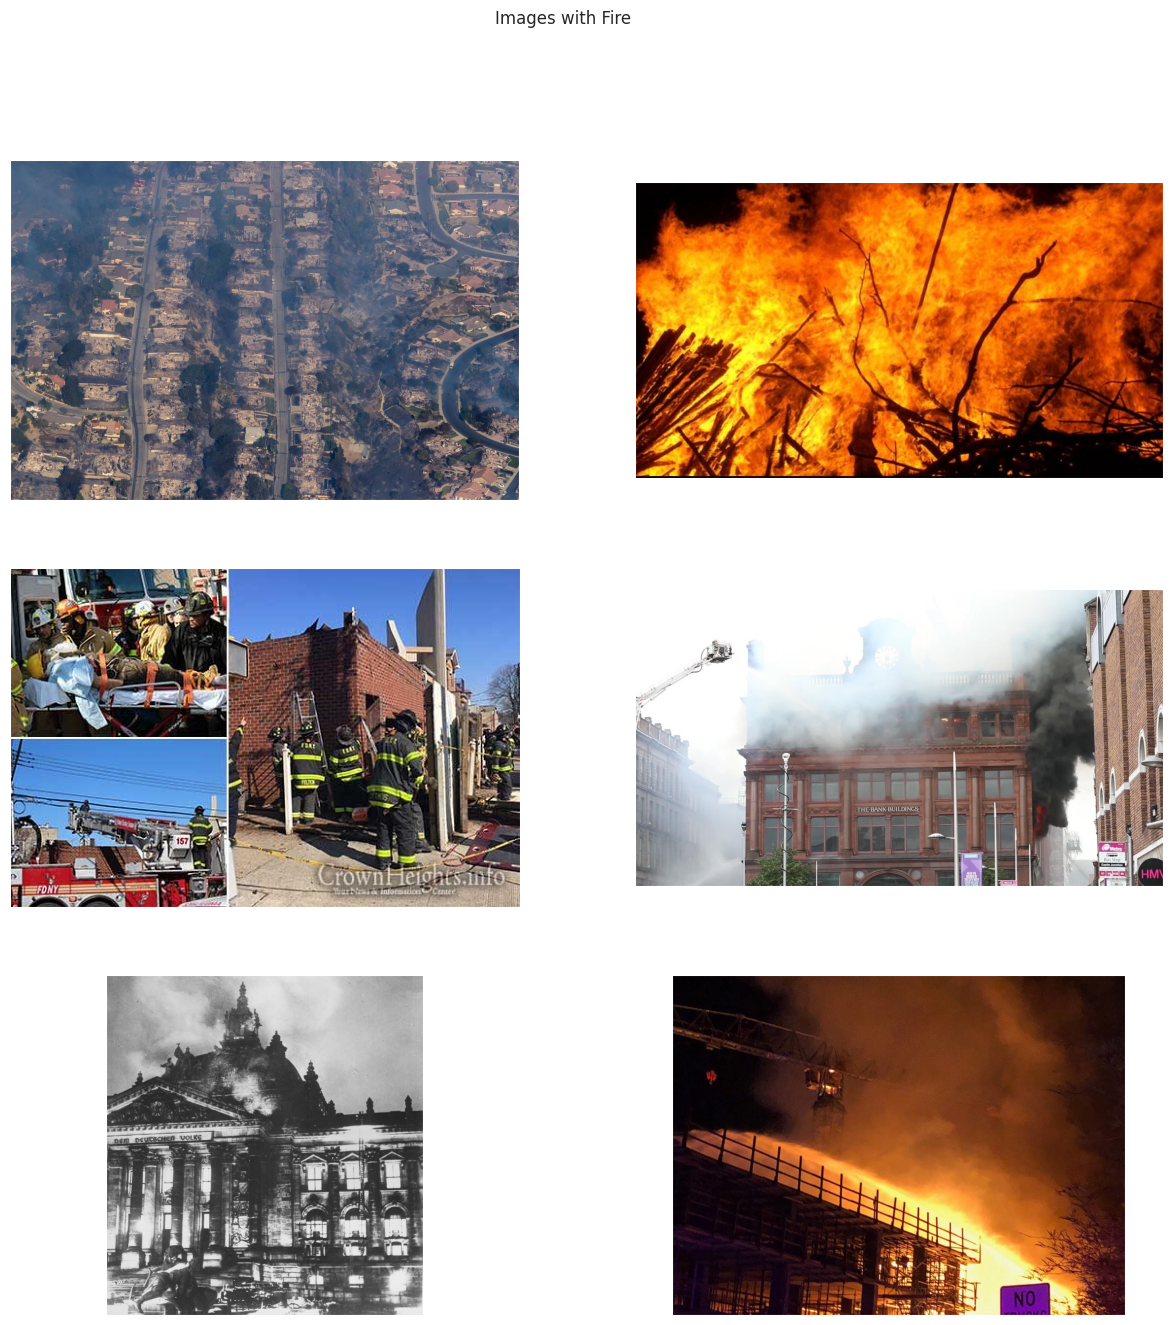

In [52]:
label = 'fire' #label for images with fire
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

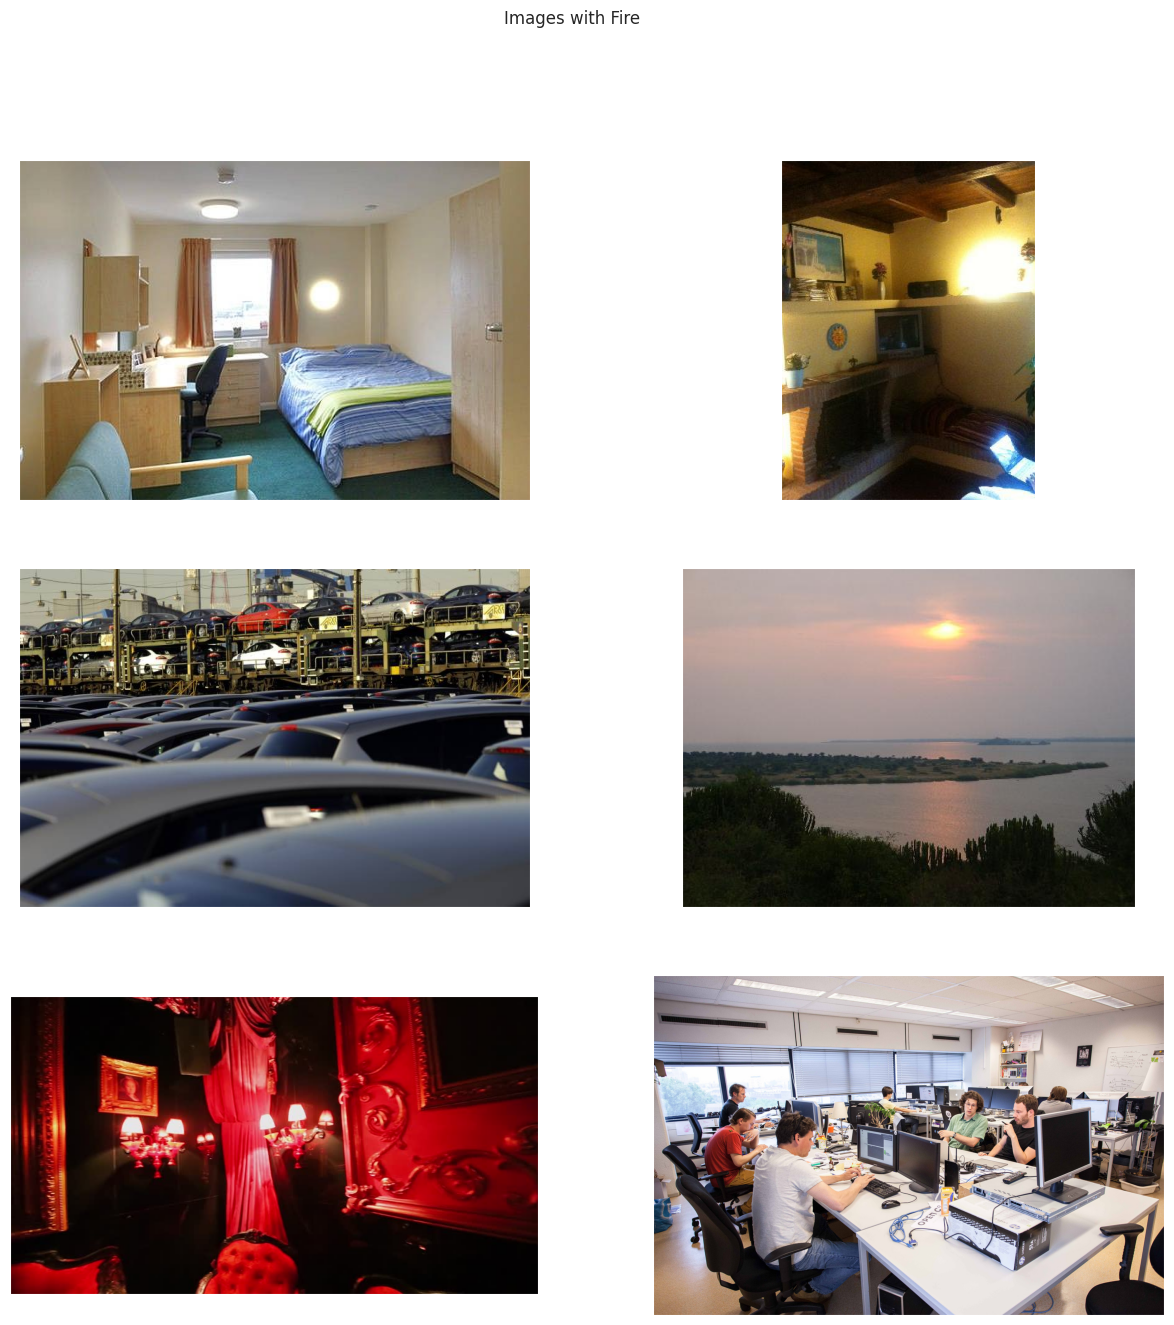

In [53]:
label = 'non_fire' #label for images without fire
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

In [54]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

path     label  height  width
0  /content/drive/MyDrive/Fire detector/Fire/non_...  non_fire     640    480
1  /content/drive/MyDrive/Fire detector/Fire/fire...      fire     568    320
2  /content/drive/MyDrive/Fire detector/Fire/fire...      fire     480    640
3  /content/drive/MyDrive/Fire detector/Fire/non_...  non_fire     334    740
4  /content/drive/MyDrive/Fire detector/Fire/non_...  non_fire    2362   3543

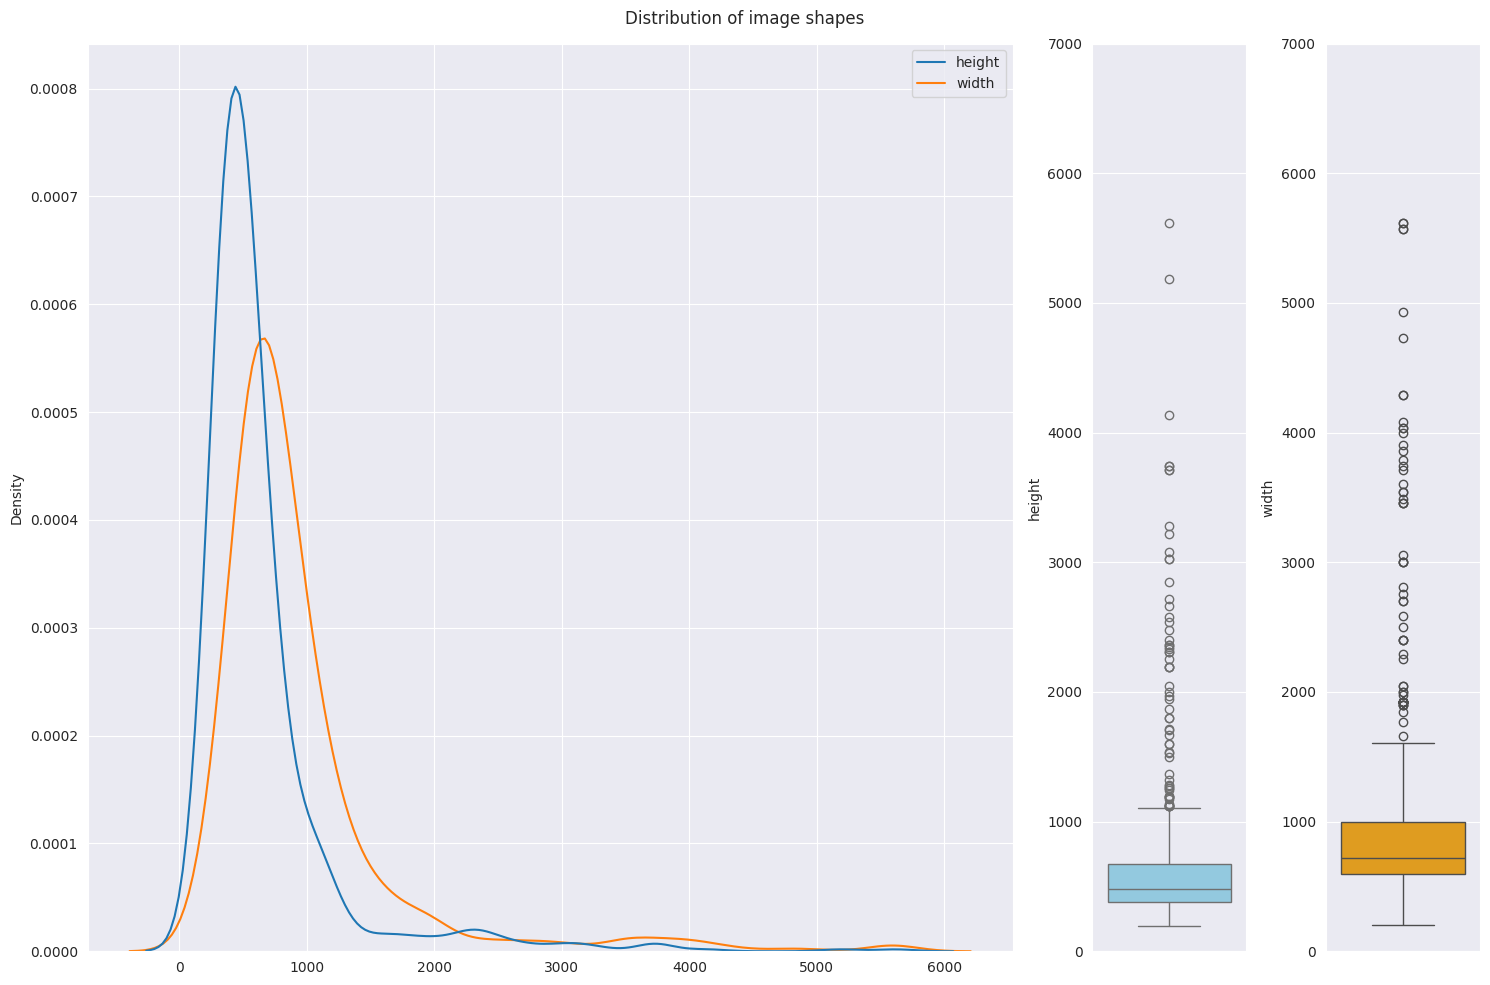

In [55]:
sns.set_style('darkgrid')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios': [3,0.5,0.5]},figsize=(15,10))
sns.kdeplot(data=df.drop(columns=['path','label']),ax=ax1,legend=True)
sns.boxplot(data=df,y='height',ax=ax2,color='skyblue')
sns.boxplot(data=df,y='width',ax=ax3,color='orange')
plt.suptitle('Distribution of image shapes')
ax3.set_ylim(0,7000)
ax2.set_ylim(0,7000)
plt.tight_layout()

#### The height and width of images vary too much. We have to reshape them to a fixed shape before training

## Image Generation or Augmentation

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [57]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

Creating the training and test generator

### We will use the flow_from_dataframe method of the ImageDataGenerator class. It will take the path of the images from the dataframe along with their labels. We construct two generators, one for training and the other for validation.

### Note: Our labels are strings 'fire ' and 'non_fire'. Image generator will automatically encode them to integer labels

In [58]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 604 validated image filenames belonging to 2 classes.
Found 151 validated image filenames belonging to 2 classes.


### Class indices assigned by the Image generator

In [59]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key

print(class_indices)

{0: 'fire', 1: 'non_fire'}


### Hence an image predicted 0 will contain fire and 1 won't.

## Visualizing the generated images in training set

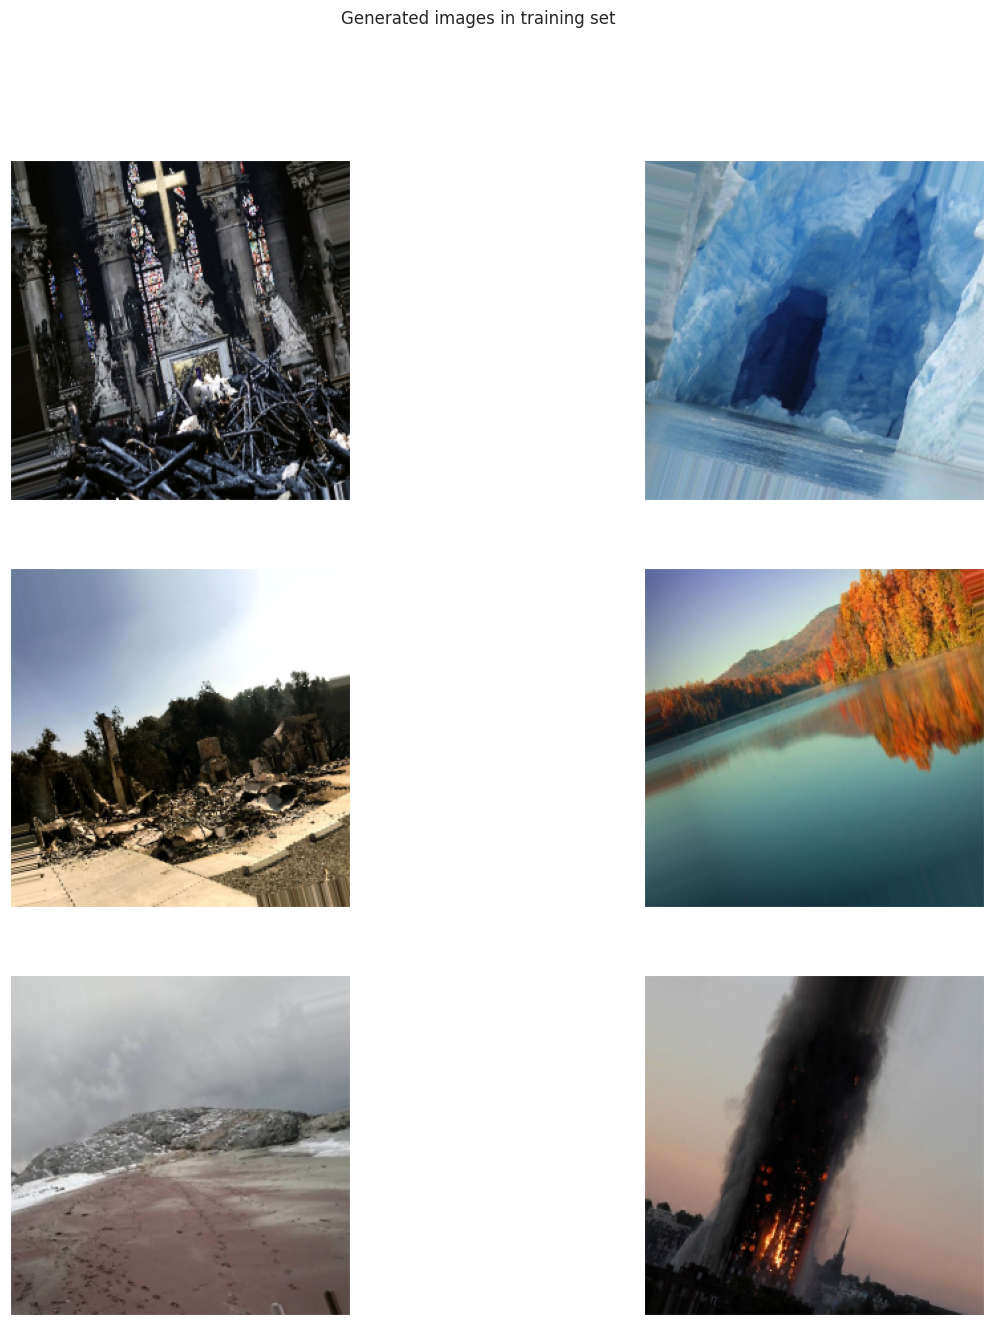

In [60]:
sns.set_style('dark')
pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

## Creating the model

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [62]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

### We increase the number of filters as we add more layers because initially there will be a lot of noise present in the input and we only need to capture the important information. Later as we progress through the layers, the feature maps become nuanced and we try to capture them with more filters

## Model Summary

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 31, 31, 128)      

## Compiling the model

In [64]:
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model

In [65]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

## Defining Callbacks

In [66]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [67]:
early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

## Model Fitting

In [68]:
model.fit(x=train_gen,batch_size=32,epochs=15,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])

Epoch 1/15
19/19 [==============================] - 107s 6s/step - loss: 0.6705 - accuracy: 0.6821 - recall_2: 0.9089 - auc_2: 0.5519 - val_loss: 0.6164 - val_accuracy: 0.6689 - val_recall_2: 1.0000 - val_auc_2: 0.6283 - lr: 0.0010
Epoch 2/15
19/19 [==============================] - 96s 5s/step - loss: 0.5613 - accuracy: 0.7285 - recall_2: 1.0000 - auc_2: 0.6334 - val_loss: 0.6074 - val_accuracy: 0.6556 - val_recall_2: 0.9802 - val_auc_2: 0.6635 - lr: 0.0010
Epoch 3/15
19/19 [==============================] - 94s 5s/step - loss: 0.5411 - accuracy: 0.7252 - recall_2: 0.9932 - auc_2: 0.6848 - val_loss: 0.5681 - val_accuracy: 0.6887 - val_recall_2: 0.9703 - val_auc_2: 0.6976 - lr: 0.0010
Epoch 4/15
19/19 [==============================] - 103s 5s/step - loss: 0.5437 - accuracy: 0.7368 - recall_2: 0.9339 - auc_2: 0.6696 - val_loss: 0.6603 - val_accuracy: 0.6556 - val_recall_2: 0.9802 - val_auc_2: 0.6750 - lr: 0.0010
Epoch 5/15
19/19 [==============================] - 97s 5s/step - loss: 0.

## Model Evaluation¶
### Plotting metrics

In [69]:
history= model.history.history
px.line(history,title = "Metrics Plot")

In [70]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

5/5 [==============================] - 12s 2s/step - loss: 0.4542 - accuracy: 0.7682 - recall_2: 0.8812 - auc_2: 0.8510
loss: 0.45
accuracy: 0.77
recall_2: 0.88
auc_2: 0.85


## Model creation by transfer learning

In [71]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [72]:
xception = Xception(include_top = False,input_shape = (256,256,3))
input_to_model = xception.input
#turn off training
xception.trainable = False

x = Flatten()(xception.output)
x = Dense(64,activation = 'relu')(x)
output_to_model = Dense(1,activation = 'sigmoid')(x)
model2 = Model(inputs = input_to_model,outputs = output_to_model)

83683744/83683744 [==============================] - 1s 0us/step


## Compiling the model

In [73]:
model2.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy',Recall(),AUC()])

## Fitting the model

In [74]:
history2 = model2.fit(x = train_gen,batch_size=32,epochs=15,callbacks = [early_stoppping,reduce_lr_on_plateau],validation_data = val_gen)

Epoch 1/15
19/19 [==============================] - 275s 14s/step - loss: 2.2351 - accuracy: 0.5430 - recall_3: 0.5877 - auc_3: 0.4808 - val_loss: 0.6922 - val_accuracy: 0.6689 - val_recall_3: 1.0000 - val_auc_3: 0.5000 - lr: 0.0010
Epoch 2/15
19/19 [==============================] - 290s 15s/step - loss: 0.6279 - accuracy: 0.7268 - recall_3: 1.0000 - auc_3: 0.5578 - val_loss: 0.5806 - val_accuracy: 0.6689 - val_recall_3: 1.0000 - val_auc_3: 0.6535 - lr: 0.0010
Epoch 3/15
19/19 [==============================] - 260s 14s/step - loss: 0.3988 - accuracy: 0.7334 - recall_3: 0.9977 - auc_3: 0.8545 - val_loss: 0.5175 - val_accuracy: 0.6755 - val_recall_3: 0.9703 - val_auc_3: 0.8524 - lr: 0.0010
Epoch 4/15
19/19 [==============================] - 297s 16s/step - loss: 0.2738 - accuracy: 0.8791 - recall_3: 0.9362 - auc_3: 0.9450 - val_loss: 0.2922 - val_accuracy: 0.9007 - val_recall_3: 0.9307 - val_auc_3: 0.9490 - lr: 0.0010
Epoch 5/15
19/19 [==============================] - 292s 15s/step - 

## Model Evaluation

In [75]:
px.line(history,title='Metrics Plot')

In [76]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

5/5 [==============================] - 10s 2s/step - loss: 0.4222 - accuracy: 0.8013 - recall_2: 0.9208 - auc_2: 0.8766
loss: 0.42
accuracy: 0.80
recall_2: 0.92
auc_2: 0.88


## Example Prediction¶
**Let's use an image of the apartment complex in Texas that caught fire in February 2021**.

### News link : https://www.nytimes.com/2021/02/19/us/san-antonio-fire-hydrants-water.html

In [77]:
#Downloading the image
!curl https://static01.nyt.com/images/2021/02/19/world/19storm-briefing-texas-fire/19storm-briefing-texas-fire-articleLarge.jpg --output predict.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50241  100 50241    0     0   189k      0 --:--:-- --:--:-- --:--:--  190k


### Printing the image

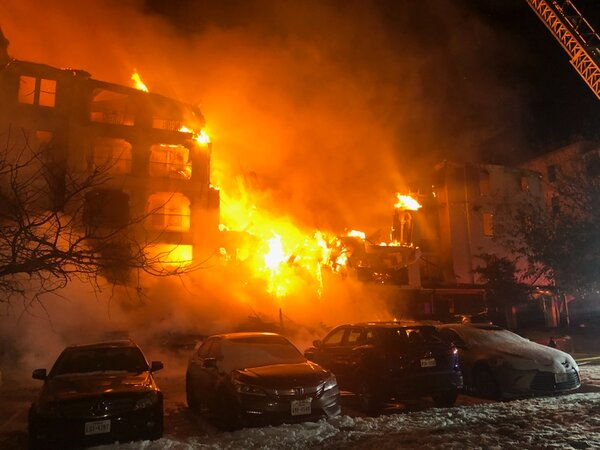

In [78]:
#loading the image
img = image.load_img('predict.jpg')
img

### Resizing the image and expanding its dimension to include the batch size - 1

In [79]:
img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)

print("Image Shape",img.shape)

Image Shape (1, 256, 256, 3)


### Prediction

In [80]:
prediction = int(tf.round(model2.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

1/1 [==============================] - 2s 2s/step
The predicted value is:  0 and the predicted label is: fire


## Thank You